In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

In [3]:
df = pd.read_csv("data/Clean_Dataset.csv",index_col=0)

In [4]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [5]:
df.shape

(300153, 11)

__TOTAL NUMBER OF:__

- __`ROWS`:__ 300153

- __`COLUMNS`:__ 11

In [6]:
df_train_full, df_test = train_test_split(df, test_size=0.2,random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25,random_state=42)

In [7]:
df_train.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

- No column has null.

In [8]:
def plot_counter_plot(data,column):
    """
     Plots count of each category in the dataset
     ARGS: 
         data    -> dataframe (data where column exist)
         columns -> string (identified column to obtain chart)
    """
    data = data.groupby([column])[column].count()
    
    data1 = pd.DataFrame()
    data1[column] = data.index
    data1["count"] = data.values
    
    data1.sort_values(by=["count"], inplace = True,ascending=False)
    
    ax = sns.barplot(x=data1[column], y=data1["count"])
    #for i in ax.containers:
        #ax.bar_label(i,)

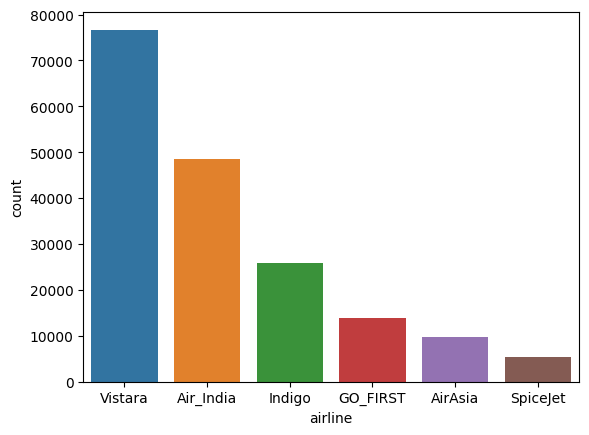

In [9]:
plot_counter_plot(df_train,"airline")

- Most travelled airlines in india are 
    1. `Vistara = 76542` 
    
    2. `Air India = 48635`
    
    3. `Indigo = 25885`
    
    4. `Go First = 13853`
    
    5. `Air Asia = 9747`
    
    6. `Spice Jet = 5429`

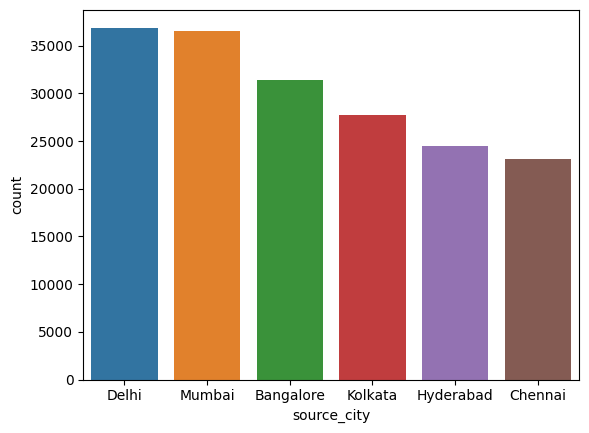

In [10]:
plot_counter_plot(df_train, "source_city")

- Cities from where most aeroplane take off (Source city)
    1. `Delhi = 36890` 
    
    2. `Mumbai = 36470`
    
    3. `Banglore = 31355`
    
    4. `Kolkata = 27822`
    
    5. `Hyderabad = 24479`
    
    6. `Chennai = 23075`

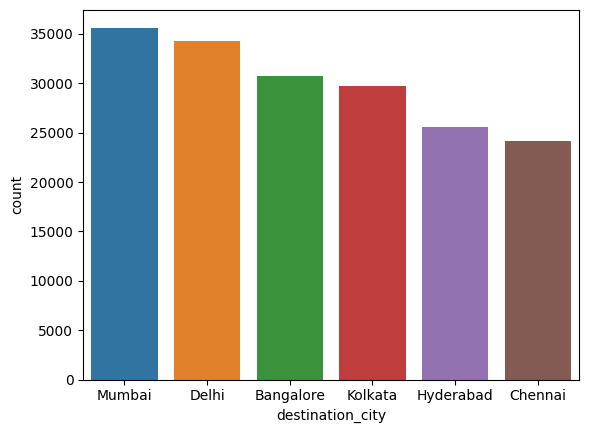

In [11]:
plot_counter_plot(df_train, "destination_city")

- Cities where most aeroplane landed (Destination city).
    1. `Mumbai = 35632`
    
    2. `Delhi = 34225` 
    
    3. `Banglore = 30756`
    
    4. `Kolkata = 29760`
    
    5. `Hyderabad = 25562`
    
    6. `Chennai = 24156`

In [12]:
df_train["source_destination"] = df_train["source_city"] +"_"+ df_train["destination_city"]

In [13]:
def get_count_result(data,column):
    """
     count the occurence of each category and return the dataframe in descending order by count
     ARGS: 
         data    -> dataframe (data where column exist)
         columns -> string (identified column to get count)
    """
    data = data.groupby([column])[column].count()
    
    data1 = pd.DataFrame()
    data1[column] = data.index
    data1["count"] = data.values
    
    data1.sort_values(by=["count"], inplace = True,ascending=False)
    return data1.reset_index(drop=True)

In [14]:
data = get_count_result(df_train,column="source_destination")
data.head(5)

,source_destination,count
0,Delhi_Mumbai,9163
1,Mumbai_Delhi,8894
2,Delhi_Bangalore,8525
3,Bangalore_Delhi,8252
4,Bangalore_Mumbai,7782


- Top 5 india cities which has highest connectivity through airways are.
    |__FROM__|__TO__|count|
    |:------:|:---:|:---:|
    |Dehi|Mumbai|9236|
    |Mumbai|Delhi|8907|
    |Delhi|Bangalore|8427|
    |Bangalore|Delhi|8297|
    |Bangalore|Mumbai|7866|
    

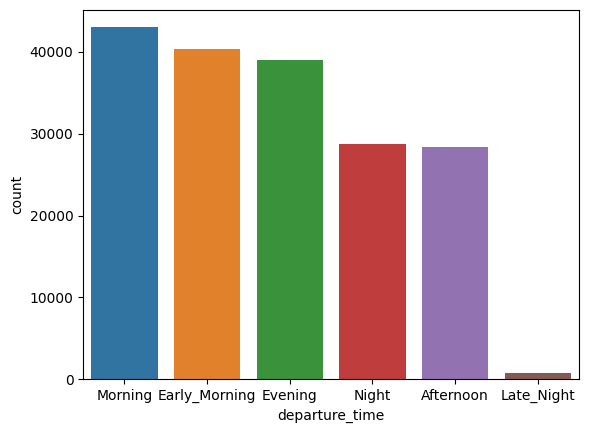

In [15]:
plot_counter_plot(df_train,"departure_time")

- When most airplane departs.

    1. `Morning = 42945`
    
    2. `Early_Morning = 40281` 
    
    3. `Evening = 38992`
    
    4. `Night = 28673`
    
    5. `Afternoon = 28418`
    
    6. `Late_Night = 782`

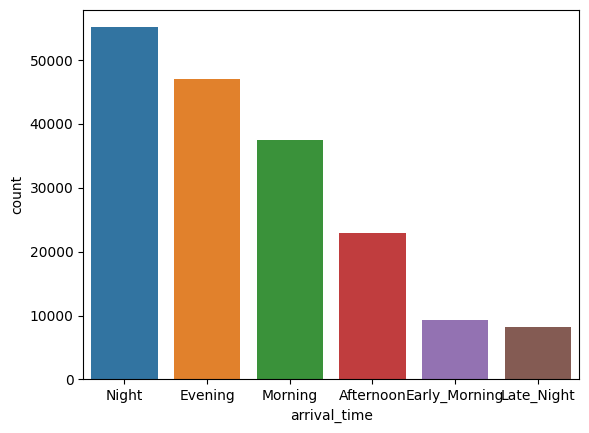

In [16]:
plot_counter_plot(df_train,"arrival_time")


- When most airplane arrives.

    1. `Night = 55080`
    
    2. `Evening = 47062`
    
    3. `Morning = 37544`
    
    4. `Afternoon = 22875`
    
    5. `Early_Morning = 9279`
    
    6. `Late_Night = 8251`


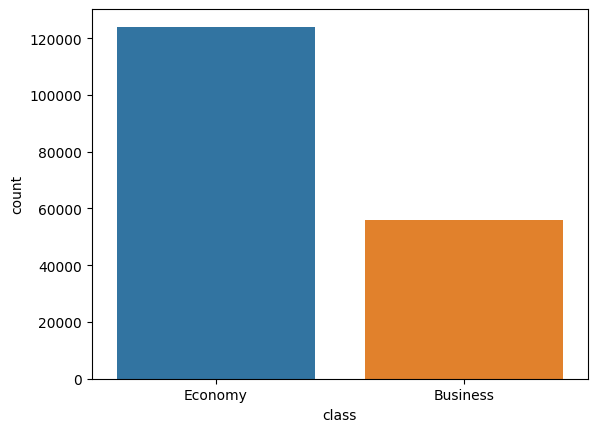

In [17]:
plot_counter_plot(df_train,"class")


- No. of tickets booked based on class.

    1. `Economy = 124034`
    
    2. `Business = 56057`

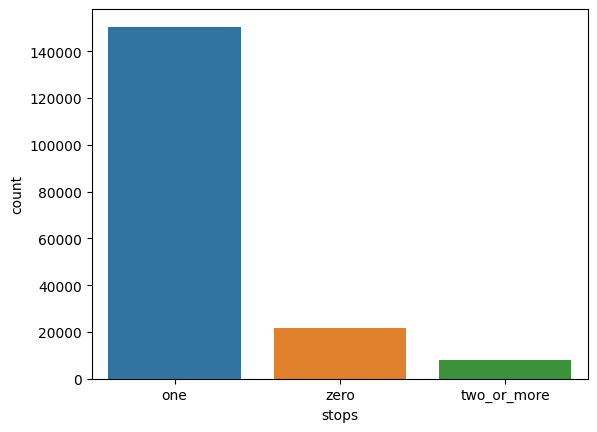

In [18]:
plot_counter_plot(df_train,"stops")


- preferred booking based on number of stops.

    1. `one = 150577`
    
    2. `zero = 21699`
    
    3. `two_or_more = 7915`
    

In [19]:
mu = round(df_train['price'].mean(),2)
print("Mean Price of the ticket is: ", mu)

Mean Price of the ticket is:  20868.05


In [20]:
def plot_distplot(data,column,hue=None,log=False):
    sns.displot(data, x=column, kind="kde",hue=hue,log_scale=log)

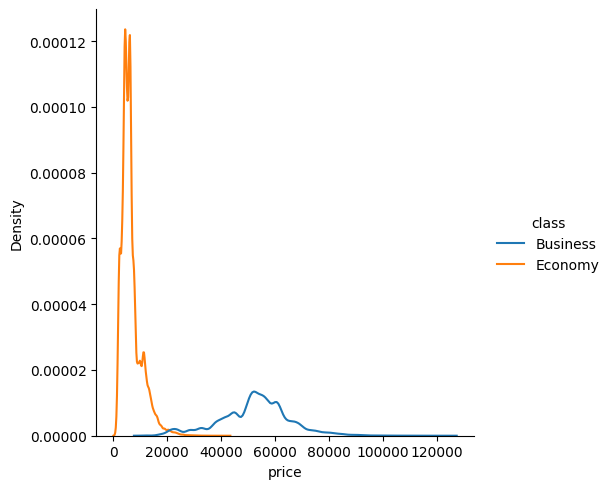

In [21]:
plot_distplot(df_train,"price",hue = "class")

__Distribution of flight fare based on class__

- Flight fare of business class ranges from 10,000 to 130,000

- Flight fare of economy class ranges to 42,000

That is a expected difference

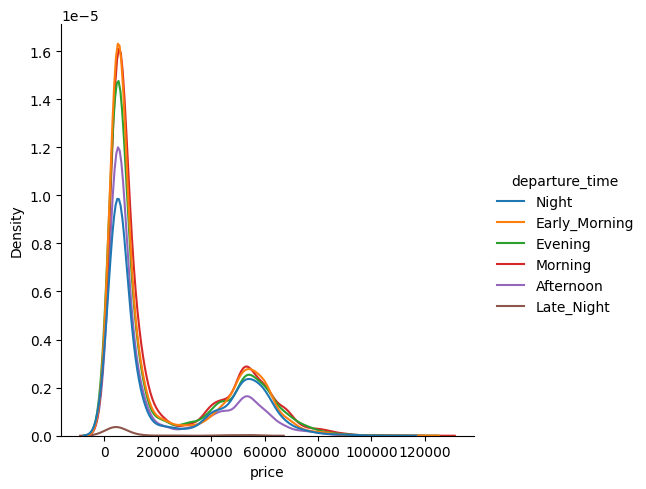

In [22]:
plot_distplot(df_train,"price",hue = "departure_time")

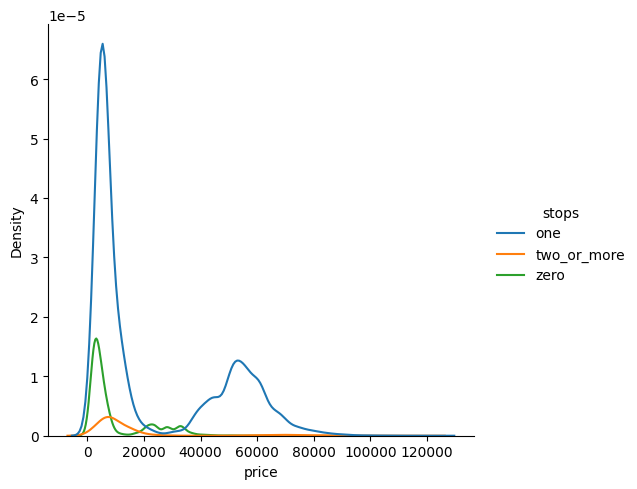

In [23]:
plot_distplot(df_train,"price",hue = "stops")

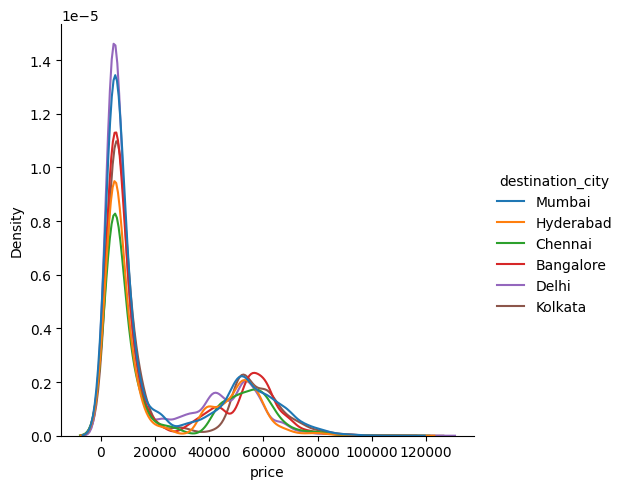

In [24]:
plot_distplot(df_train,"price",hue = "destination_city")

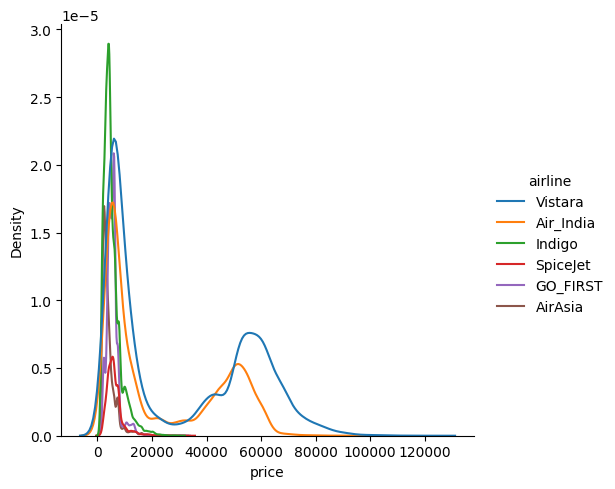

In [25]:
plot_distplot(df_train,"price",hue = "airline")

__Distribution of flight fare based on airline__

- Vistara and Air India are premium airlines their highest ticket costs more than 100,000 Rupees. 

- In low budgest Indigo is most famous carrier. 

- __`FUN FACT`__: __Vistara__ and now __Air India__ is owned by __TATA group__.

<AxesSubplot:xlabel='days_left', ylabel='price'>

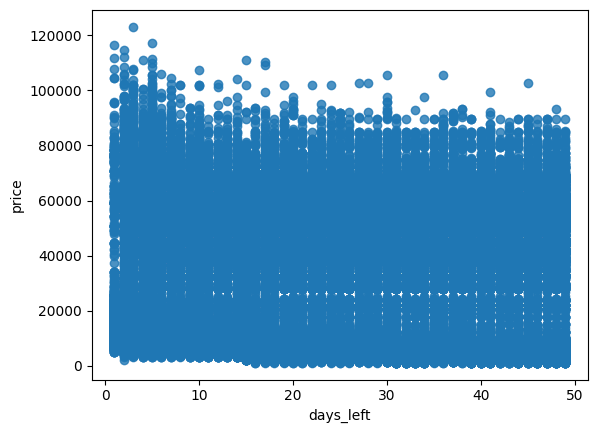

In [26]:
sns.regplot(x="days_left", y="price", data=df_train)

### Modeling

In [27]:
X_col = ['airline', 'source_city', 'departure_time','stops',
       'arrival_time', 'destination_city', 'class','days_left']

y_col = 'price'

In [28]:
X_train = df_train[X_col]
y_train = df_train[y_col]

X_val  = df_val[X_col]
y_val  = df_val[y_col]

X_test = df_test[X_col]
y_test = df_test[y_col]

In [29]:
X_train_dict = X_train.to_dict(orient='records')
X_val_dict   = X_val.to_dict(orient='records')
X_test_dict  = X_test.to_dict(orient='records')


dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train_dict)
X_val   = dv.transform(X_val_dict)
X_test  = dv.transform(X_test_dict)

columns = dv.feature_names_

In [29]:
def get_model_result(models,X_train,y_train,X_val,y_val):
    for i in range(len(models)):
        model = models[i]
        print("training_model... ", model)
        model.fit(X_train,y_train)
        y_val_pred   = model.predict(X_val)
        val_rmse   = round(mean_squared_error(y_val, y_val_pred)**.5,2)
        print("\tval_rmse  :", val_rmse)
        print()

In [30]:
models = [LinearRegression(),RandomForestRegressor(),lgb.LGBMRegressor(),xgb.XGBRegressor()]

In [31]:
modeling_result = get_model_result(models,X_train,y_train,X_val,y_val)

training_model...  LinearRegression()
	val_rmse  : 6754.81

training_model...  RandomForestRegressor()
	val_rmse  : 4413.45

training_model...  LGBMRegressor()
	val_rmse  : 4222.74

training_model...  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)
	val_rmse  : 4003.54



- XGBoost model gave best `rmse` lets apply `hyperparameter` tuning on __XGBOOST__ model 

In [33]:
def get_rmse(model, X_train,y_train, X_val,y_val):
    model.fit(X_train,y_train)
    y_val_pred   = model.predict(X_val)
    val_rmse   = round(mean_squared_error(y_val, y_val_pred)**.5,2)
    print("\tval_rmse  :", val_rmse)

### Hyperparameter Tuning
 - Linear Rrgression

In [33]:
def get_linear_model_result(params,X_train,y_train):
    lr = LinearRegression()
    model = RandomizedSearchCV(estimator=lr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
    model.fit(X_train,y_train)
    return model

In [34]:
params = { 'fit_intercept': [True,False],
           'normalize': [True,False],
           'positive': [True,False],
           'n_jobs':[-1]}

linear_model = get_linear_model_result(params,X_train,y_train)
print(linear_model.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'positive': False, 'normalize': False, 'n_jobs': -1, 'fit_intercept': True}


In [35]:
linear_model = LinearRegression(positive=False, 
                                normalize=False, 
                                n_jobs=-1, 
                                fit_intercept=True)
get_rmse(linear_model, X_train,y_train, X_val,y_val)

	val_rmse  : 6754.81


- Random Forest

In [36]:
def get_random_forest_model_result(params,X_train,y_train):
    rf = RandomForestRegressor()
    model = RandomizedSearchCV(estimator=rf,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
    model.fit(X_train,y_train)
    return model

In [37]:
params = { 'n_estimators': [120,300,500,800,1200],
           'max_depth': [5,8,15,25,30,None],
           'min_samples_split': [2,5,10,15,100],
           'min_samples_leaf': [1,2,5,10],
           'n_jobs':[-1]}

rf_model = get_random_forest_model_result(params,X_train,y_train)
print(rf_model.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'n_jobs': -1, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 25}


In [38]:
rf_model = RandomForestRegressor(n_estimators=500, 
                                max_depth=25, 
                                min_samples_split=10, 
                                min_samples_leaf=10,
                                n_jobs=-1)
get_rmse(linear_model, X_train,y_train, X_val,y_val)

	val_rmse  : 6754.81


In [39]:
def get_lgbm_model_result(params,X_train,y_train):
    lgbm = lgb.LGBMRegressor()
    model = RandomizedSearchCV(estimator=lgbm,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
    model.fit(X_train,y_train)
    return model

In [40]:
params = { 'learning_rate':[0.001,0.003,0.01,0.03],
           'n_estimators': [120,300,500,800,1200],
           'max_depth': [5,8,15,25,30,None],
           'colsample_bytree': np.arange(0.4, 1.0, 0.2),
           'max_depth': [5,8,15,25,30,None],
           'n_jobs':[-1]}

lgbm_model = get_lgbm_model_result(params,X_train,y_train)
print(lgbm_model.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'n_jobs': -1, 'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.03, 'colsample_bytree': 0.8000000000000002}


In [41]:
lgbm_model = lgb.LGBMRegressor(n_jobs=-1, 
                               n_estimators=800, 
                               max_depth=8, 
                               learning_rate=0.03, 
                               colsample_bytree=0.8)
get_rmse(lgbm_model, X_train,y_train, X_val,y_val)

	val_rmse  : 4076.32


In [30]:
def get_xgb_model_result(params,X_train,y_train):
    xgbr = xgb.XGBRegressor(seed = 20)
    model = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
    model.fit(X_train,y_train)
    return model

In [36]:
params = { 'max_depth': [5,8,15,25,30,None],
           'learning_rate': [0.001,0.003,0.01,0.03],
           'subsample': np.arange(0.4, 1.0, 0.2),
           'colsample_bytree': np.arange(0.4, 1.0, 0.2),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.2),
           'n_estimators': [120,300,500,800,1200],
           'n_jobs':[-1]}

xgb_model = get_xgb_model_result(params,X_train,y_train)
print(xgb_model.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'subsample': 0.8000000000000002, 'n_jobs': -1, 'n_estimators': 1200, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.4}


In [37]:
xgb_model = xgb.XGBRegressor(subsample=0.4,
                         n_jobs=-1,
                         n_estimators=80,
                         max_depth=15,
                         learning_rate=0.01,
                         colsample_bytree=0.6,
                         colsample_bylevel=0.4)
get_rmse(xgb_model, X_train,y_train, X_val,y_val)

	val_rmse  : 15505.59


`LightGBM` model has lowest __RMSE__, hence to train the final model, I have chosen `LigthGBM` model: checkout __`train.py`__ file